In [183]:
# import modules
import random
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
from pathlib import Path
import os
cwd = os.getcwd()
import statsmodels.stats.moment_helpers
from datetime import datetime
import multiprocessing as mp
import csv
import networkx as nx
#import seaborn as sns
from IPython.display import HTML
from matplotlib import animation

# Setup

## Parameters

In [184]:

plotIter=1000
nnodes=100
p_link=.1
leak=.25 #
lrate_wmat=.1
lrate_targ=.01
targ_min=1
sens_offset=20
movement_amp=1
input_amp=5

## Plotting

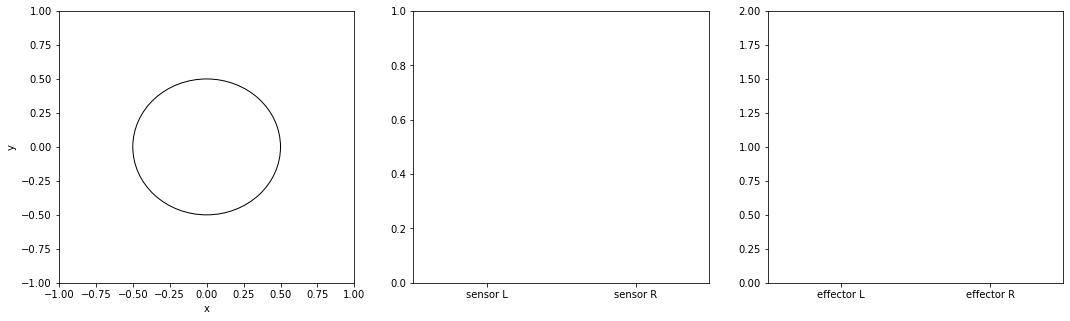

In [185]:
# create a figure and axes
fig = plt.figure(figsize=(18,5))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

# set up the subplots as needed
ax1.set_xlim(( -1, 1))            
ax1.set_ylim((-1, 1))
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.set_ylim((0, 1))
ax3.set_ylim((0, 2))

circle1 = plt.Circle((0, 0), 0.5, color='black', fill = 0)
ax1.add_patch(circle1)

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('')
pt1, = ax1.plot([], [], 'g.', ms=30)
s1, = ax1.plot([],[], 'r.', ms =20)
s2, = ax1.plot([],[], 'b.', ms =20)
bar1_plt2, bar2_plt2 = ax2.bar(['sensor L', 'sensor R'],[0,0])
bar1_plt3, bar2_plt3 = ax3.bar(['effector L', 'effector R'],[0,0])

## Set up sensor nodes and input connections

In [186]:
sensory_nodes=[]
input_wmat=np.zeros((2,nnodes))
for row in range(input_wmat.shape[0]):
    for col in range(nnodes):
        input_wmat[row,col]=random.choices([0,input_amp], weights=(1-p_link,p_link), k=1)[0]
        if input_wmat[row,col] > 0:
            sensory_nodes.append(col)
        
#select two random nodes to be output nodes
output_nodes = random.sample(range(1, nnodes), 2)
while (output_nodes[0] in sensory_nodes) or (output_nodes[1] in sensory_nodes):
    output_nodes = random.sample(range(1, nnodes), 2)

np.unique(sensory_nodes)
#output_nodes

array([ 8, 17, 18, 20, 22, 27, 32, 46, 52, 61, 65, 68, 69, 81, 82, 89, 90,
       92, 93, 94, 95, 96, 98, 99])

In [187]:
output_nodes

[10, 87]

## Set up internal weight matrix

In [188]:
link_mat = np.zeros((nnodes,nnodes))
for row in range(link_mat.shape[0]):
    for col in range(link_mat.shape[1]):
        if row == col:
            continue
        link_mat[row,col] = random.choices([0,1], weights=(1-p_link,p_link), k=1)[0]
# link_mat[:,:]=1
# np.fill_diagonal(link_mat,0)
        
wmat=np.zeros((nnodes,nnodes))
for row in range(wmat.shape[0]):
    for col in range(wmat.shape[1]):
        if link_mat[row,col] == 1:
            wmat[row,col] = np.random.normal(0,1)
            
start_wmat=wmat.copy()

## Functions

In [189]:
def get_plot_vals(degree, heading):
    x = np.sin(2 * np.pi * degree/360)
    y = np.cos(2 * np.pi * degree/360)
    
    sLdeg = heading - sens_offset
    if sLdeg > 360:
        sLdeg = sLdeg - 360
    if sLdeg <0:
        sLdeg = sLdeg + 360
        
    dL = np.abs(degree - sLdeg)
    if dL > 180:
        dL = 360 - dL
        
    sRdeg = heading + sens_offset
    if sRdeg > 360:
        sRdeg = sRdeg - 360
    if sRdeg < 0:
        sRdeg = sRdeg + 360
    
    s1x = .5 * np.sin(2 * np.pi * (sLdeg)/360)
    s1y = .5 * np.cos(2 * np.pi * (sLdeg)/360)
    
    s2x = .5 * np.sin(2 * np.pi * (sRdeg)/360)
    s2y = .5 * np.cos(2 * np.pi * (sRdeg)/360)
    
    return x, y, s1x, s1y, s2x, s2y

def move_stim(degree):
    degree -= 1
    if degree == 360:
        degree = 0
    if degree == -1:
        degree = 359

    return degree

def rotate_agent(output_acts, output_spikes, heading):
    diff = (output_acts[0] - output_acts[1])*movement_amp
    #diff = (output_spikes[0] - output_spikes[1])*movement_amp
    heading = heading + diff
    
    if heading > 360:
        heading = heading - 360
    if heading < 0:
        heading = heading + 360
    
    return heading

def get_input_acts(heading, degree):
    d1 = np.abs(degree - heading + sens_offset)
    if d1 > 180:
        d1 = 360 - d1

    d2 = np.abs(degree - heading - sens_offset)
    if d2 > 180:
        d2 = 360 - d2
    
#     if d1 > 60:
#         d1 = 60
#     if d2 > 60:
#         d2 = 60
        
    s1_act = 1 - d1/180 #d1/60 for negative influence
    s2_act = 1 - d2/180
    
    return [s1_act, s2_act], [d1, d2]

def get_acts(acts,leak,spikes,wmat,input,input_wmat,targets):
    acts = acts*(1-leak) + np.dot(input, input_wmat) + np.dot(spikes, wmat)
    acts[acts<0]=0
    
    thresholds = targets*2
    #CAN I MAKE NEURONS SPIKE MORE THAN ONCE IN THE TIME FRAME, eg spikes = np.floor(acts/thresholds) 
    #spikes = np.floor(acts/thresholds)
    spikes[acts >= thresholds]=1
    spikes[acts < thresholds]=0
    
    acts[spikes==1]=acts[spikes==1]-thresholds[spikes==1]
    #acts = acts - thresholds*spikes
       
    errors=acts-targets
    
    output_acts = acts[output_nodes]
    output_spikes = spikes[output_nodes]
    
    return acts, spikes, errors, output_acts, output_spikes

def learning(learn_on,link_mat,prev_spikes, errors,wmat,targets):
    prev_active= np.argwhere(prev_spikes > 0)[:,0]
    prev_inactive = np.argwhere(prev_spikes<=0)[:,0]
    
    active_neighbors=link_mat.copy()
    active_neighbors[prev_inactive,:]=0
    active_neighbors=np.sum(active_neighbors,axis=0)#+np.repeat(1,nnodes)
    
    if learn_on==1:
        if np.sum(active_neighbors) >0:
            d_wmat = np.zeros((nnodes,nnodes))
            d_wmat[:,:]=errors*lrate_wmat
            d_wmat[link_mat==0]=0
            d_wmat[prev_inactive,:]=0
            d_wmat=(d_wmat/active_neighbors)
            d_wmat=np.nan_to_num(d_wmat)
            wmat-=d_wmat
            
        targets=targets+(errors*lrate_targ) # could multiply by acts, so that this value naturally can't go below 0? but that will also amplify the change when acts are very high
        targets[targets<targ_min]=targ_min
        
    return wmat, targets



# Run the model

In [190]:
spikes=np.zeros(nnodes)
targets=np.repeat(targ_min,nnodes)
acts=np.zeros(nnodes)
input_acts = np.zeros(2)
output_acts = np.zeros(2)
# output_spikes = np.zeros(2)
# output_targets = np.repeat(targ_min,2)
MeanAbsErs=[]
MeanActs =[]
MeanSpikes=[]

i=1
degree = 0
heading = 180
learn_on=1
def drawframe(n):
    global degree, heading, acts, input_acts, output_acts, output_spikes,leak, spikes, prev_spikes, wmat, input_wmat, output_wmat, targets, errors,MeanAbsErs,MeanActs,MeanSpikes
    
    input, dists = get_input_acts(heading, degree)
        
    prev_spikes = spikes.copy()
    
    acts, spikes, errors, output_acts, output_spikes = get_acts(acts,leak,spikes,wmat,input,input_wmat,targets)
        
#     if((n % 1000 ==0) & (t ==1)):
#         print(' ')

    if (n % 100 !=0):
        MeanAbsEr = np.mean(np.abs(errors))
        MeanAbsErs.append(MeanAbsEr)
        MeanAct = np.mean(acts)
        MeanActs.append(MeanAct)
        MeanSpike = np.mean(spikes)
        MeanSpikes.append(MeanSpike)
        #print('iteration: ', n, ' ; MeanAbsEr: ',MeanAbsEr, ' ; MeanAct: ', MeanAct)
    else:
        MeanAbsEr = np.mean(np.abs(errors))
        MeanAbsErs.append(MeanAbsEr)
        MeanAct = np.mean(acts)
        MeanActs.append(MeanAct)
        MeanSpike = np.mean(spikes)
        MeanSpikes.append(MeanSpike)
        
        MeanAbsErs_ = np.mean(MeanAbsErs)
        MeanActs_ = np.mean(MeanActs)
        MeanSpikes_ = np.mean(MeanSpikes)
        print('iteration: ', str(n), ' ; MeanAbsErs: ',str(MeanAbsErs_), ' ; MeanAct: ', str(MeanActs_), '; MeanSpikes: ', str(MeanSpikes_))
        MeanAbsErs=[]
        MeanActs=[]
        MeanSpikes=[]
        
    
    wmat, targets = learning(learn_on,link_mat,prev_spikes, errors, wmat,targets)
    #acts=acts-((targets*2)*spikes)
    
    x, y, s1x, s1y, s2x, s2y = get_plot_vals(degree, heading)
    
    degree = move_stim(degree)
    heading = rotate_agent(output_acts, output_spikes,heading)
    
    pt1.set_data(x,y)
    s1.set_data(s1x,s1y)
    s2.set_data(s2x,s2y)
    bar1_plt2.set_height(input[0])
    bar2_plt2.set_height(input[1])
    bar1_plt3.set_height(output_acts[0])
    bar2_plt3.set_height(output_acts[1])
    
    txt_title.set_text('Frame = {0:4d}'.format(n))
    #print('degree = ' + str(degree) + ' ; heading = ' + str(heading))
    #print('input = ' + str(input))
    #print('dists = ' + str(dists))
    #print(n)
    
    return (pt1,s1,s2)
        


In [191]:
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=plotIter, interval=10, blit=False)

In [192]:
HTML(anim.to_html5_video())

iteration:  0  ; MeanAbsErs:  0.86  ; MeanAct:  0.1444444444444445 ; MeanSpikes:  0.0
iteration:  0  ; MeanAbsErs:  0.7838666666666667  ; MeanAct:  0.25388888888888894 ; MeanSpikes:  0.0


/Users/jbenfalandays/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in true_divide


iteration:  100  ; MeanAbsErs:  0.6622239703635803  ; MeanAct:  0.909753768536464 ; MeanSpikes:  0.33089999999999997
iteration:  200  ; MeanAbsErs:  0.6281147230679579  ; MeanAct:  1.123281427751151 ; MeanSpikes:  0.4273
iteration:  300  ; MeanAbsErs:  0.6370336566779878  ; MeanAct:  0.809863192289354 ; MeanSpikes:  0.1321
iteration:  400  ; MeanAbsErs:  0.5715485604761759  ; MeanAct:  0.9943146881847399 ; MeanSpikes:  0.34820000000000007
iteration:  500  ; MeanAbsErs:  0.5045198097226706  ; MeanAct:  1.2317439622084247 ; MeanSpikes:  0.6174000000000001
iteration:  600  ; MeanAbsErs:  0.4731512035345298  ; MeanAct:  1.1662041287104246 ; MeanSpikes:  0.41980000000000006
iteration:  700  ; MeanAbsErs:  0.49432189742647703  ; MeanAct:  0.9204704108998802 ; MeanSpikes:  0.16060000000000002
iteration:  800  ; MeanAbsErs:  0.47060820567229483  ; MeanAct:  0.8822546579824876 ; MeanSpikes:  0.08690000000000002
iteration:  900  ; MeanAbsErs:  0.2626709046902927  ; MeanAct:  1.1339803530752817 ;